## In this notebook we will look at a sparse, unbalanced dataset, balance it with under-sampling and with SMOTE, and use deep neural networks with keras to attempt to classify the data.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.models import Model
from keras import regularizers
import random
import matplotlib.pyplot as plt
import collections
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve
import time
from sklearn.model_selection import train_test_split

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
df = pd.read_csv("../train.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56020 entries, 0 to 56019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 158.6 MB
None


In [4]:
fraudocc = df['TARGET'].value_counts()
print(fraudocc)

print("Ratio of fraud cases:")
print(fraudocc/len(df))

0    53814
1     2206
Name: TARGET, dtype: int64
Ratio of fraud cases:
0    0.960621
1    0.039379
Name: TARGET, dtype: float64


In [5]:
df.describe()

,ID,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_360,var_361,var_362,var_363,var_364,var_365,var_366,var_367,var_368,TARGET
count,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,...,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,5.602000e+04,56020.000000
mean,38006.087701,-1478.918761,33.176455,90.577048,71.914411,118.527881,3.308784,5.980358,0.351521,0.534811,...,7.061389,1.186156,12.682248,8.813963,33.439499,1.724232,76.339788,56.126032,1.170350e+05,0.039379
std,21965.342957,38463.619817,12.925293,1779.782881,338.520271,541.712773,89.095332,145.400358,19.645287,30.005879,...,427.464112,110.490491,852.152706,571.506477,2282.092562,146.961440,4244.942998,2960.886733,1.868549e+05,0.194496
min,0.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,18941.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.792923e+04,0.000000
50%,38044.500000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.065634e+05,0.000000
75%,57075.250000,2.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.188930e+05,0.000000
max,76019.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,1800.000000,3810.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
#It looks like -999999.000000 is the assignment for a NaN
df=df.replace(-999999.000000,np.nan)
df.isnull().values.any()

True

In [7]:
df[(df.isnull().any(axis=1)) & (df["TARGET"]==1)]

,ID,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_360,var_361,var_362,var_363,var_364,var_365,var_366,var_367,var_368,TARGET
40206,54652,NaN,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,1


In [8]:
# Since there are only 83 points and of them just 1 is a signal event, it should be safe to drop all the rows with NaN values
df=df.dropna()
df.shape

(55937, 371)

In [27]:
target = df.TARGET
predictors=df.drop(columns=['ID','TARGET'])

#### Now we have to balance the data, since ML algorithms don't work well on very unbalanced datasets.  We will do this two ways: under-sample the majority class and synthesize new data points for the minority class and then compare the results.

In [28]:
pred_scaled=pd.DataFrame(sklearn.preprocessing.minmax_scale(predictors))
print(pred_scaled.describe())
pred_scaled.isnull().values.any() #check for any place we might have divided by 0

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  """Entry point for launching an IPython kernel.


                0             1             2             3             4    \
count  55937.000000  55937.000000  55937.000000  55937.000000  55937.000000   
mean       0.011334      0.281743      0.000432      0.005585      0.005643   
std        0.039301      0.129270      0.008481      0.026278      0.025779   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.008403      0.180000      0.000000      0.000000      0.000000   
50%        0.008403      0.230000      0.000000      0.000000      0.000000   
75%        0.008403      0.340000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  55937.000000  55937.000000  55937.000000  55937.000000  55937.000000   
mean       0.000402      0.000541      0.000196      0.000141      0.000358   
std        0.010823      0.013140      0.010922    

False

In [29]:
rus = RandomUnderSampler(random_state=0)
X_undersampled, y_undersampled = rus.fit_resample(pred_scaled, target)

In [30]:
# Check that undersampling worked:
len([i for i in y_undersampled if i==1]) == len([i for i in y_undersampled if i==0])

True

In [31]:
method = SMOTE(kind='regular')

# Create the resampled feature set
X_oversampled, y_oversampled = method.fit_sample(pred_scaled, target)

In [32]:
# Check that oversampling worked:
len([i for i in y_oversampled if i==1]) == len([i for i in y_oversampled if i==0])

True

In [42]:
dense_layers=[1,2,3,4,5,6]
n_nodes=[10, 50, 100, 150]
n_cols = pred_scaled.shape[1]
early_stopping_monitor = EarlyStopping(patience=2) #add a stopping factor so we don't have to run over all the epochs once they stop improving

for dense_layer in dense_layers:
    for n_node in n_nodes:
        name=str(dense_layer)+"_dense_layers_"+str(n_node)+"_nodes_per_layer_"+str(time.time())
        tensorboard = TensorBoard(log_dir='dnnlogs/'+str(name))
        print("Doing: ", name)
        
        model=Sequential()
        model.add(Dense(n_node, activation='relu', input_shape = (n_cols,)))
        for l in range(dense_layer):
            model.add(Dense(n_node, activation='relu'))
            model.add(Dropout(0.2))
        

        model.add(Dense(2, activation = 'softmax'))
        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(pred_scaled, target, validation_split=.3, epochs=30, callbacks=[tensorboard, early_stopping_monitor])


Doing:  1_dense_layers_10_nodes_per_layer_1548668180.188044
Train on 39155 samples, validate on 16782 samples
Epoch 1/30
39155/39155 [==============================] - 10s 252us/step - loss: 0.1913 - acc: 0.9531 - val_loss: 0.1549 - val_acc: 0.9589
Epoch 2/30
39155/39155 [==============================] - 8s 212us/step - loss: 0.1599 - acc: 0.9613 - val_loss: 0.1513 - val_acc: 0.9589
Epoch 3/30
39155/39155 [==============================] - 8s 212us/step - loss: 0.1538 - acc: 0.9613 - val_loss: 0.1490 - val_acc: 0.9589
Epoch 4/30
39155/39155 [==============================] - 8s 210us/step - loss: 0.1482 - acc: 0.9613 - val_loss: 0.1463 - val_acc: 0.9589
Epoch 5/30
39155/39155 [==============================] - 9s 221us/step - loss: 0.1448 - acc: 0.9613 - val_loss: 0.1455 - val_acc: 0.9589
Epoch 6/30
39155/39155 [==============================] - 7s 187us/step - loss: 0.1421 - acc: 0.9613 - val_loss: 0.1472 - val_acc: 0.9589
Epoch 7/30
39155/39155 [==============================] - 6s 

39155/39155 [==============================] - 15s 389us/step - loss: 0.1418 - acc: 0.9613 - val_loss: 0.1515 - val_acc: 0.9589
Doing:  4_dense_layers_150_nodes_per_layer_1548669806.577749
Train on 39155 samples, validate on 16782 samples
Epoch 1/30
39155/39155 [==============================] - 22s 571us/step - loss: 0.1586 - acc: 0.9611 - val_loss: 0.1547 - val_acc: 0.9589
Epoch 2/30
39155/39155 [==============================] - 18s 470us/step - loss: 0.1473 - acc: 0.9613 - val_loss: 0.1482 - val_acc: 0.9589
Epoch 3/30
39155/39155 [==============================] - 15s 378us/step - loss: 0.1443 - acc: 0.9613 - val_loss: 0.1529 - val_acc: 0.9589
Epoch 4/30
39155/39155 [==============================] - 19s 481us/step - loss: 0.1429 - acc: 0.9613 - val_loss: 0.1464 - val_acc: 0.9589
Epoch 5/30
39155/39155 [==============================] - 19s 487us/step - loss: 0.1416 - acc: 0.9613 - val_loss: 0.1477 - val_acc: 0.9589
Epoch 6/30
39155/39155 [==============================] - 19s 481u

Since this is an unbalanced dataset, of course this just assigned everything to be class 0 to get 96% accuracy.  Let's instead repeat on the over-sampled data.

In [46]:
dense_layers=[5, 8, 10, 12]
n_nodes=[50, 100, 200, 300]
n_cols = pred_scaled.shape[1]
early_stopping_monitor = EarlyStopping(patience=2) #add a stopping factor so we don't have to run over all the epochs once they stop improving

for dense_layer in dense_layers:
    for n_node in n_nodes:
        name="Oversampled_"+str(dense_layer)+"_dense_layers_"+str(n_node)+"_nodes_per_layer_"+str(time.time())
        tensorboard = TensorBoard(log_dir='dnnlogs/'+str(name))
        print("Doing: ", name)
        
        model=Sequential()
        model.add(Dense(n_node, activation='relu', input_shape = (n_cols,)))
        for l in range(dense_layer):
            model.add(Dense(n_node, activation='relu'))
            model.add(Dropout(0.2))
        

        model.add(Dense(2, activation = 'softmax'))
        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(X_oversampled, y_oversampled, validation_split=.3, epochs=30, callbacks=[tensorboard, early_stopping_monitor])


Doing:  Oversampled_5_dense_layers_50_nodes_per_layer_1548725325.549073
Train on 75224 samples, validate on 32240 samples
Epoch 1/30
75224/75224 [==============================] - 23s 301us/step - loss: 0.4876 - acc: 0.7685 - val_loss: 0.9558 - val_acc: 0.5247
Epoch 2/30
75224/75224 [==============================] - 22s 286us/step - loss: 0.4554 - acc: 0.7908 - val_loss: 0.6783 - val_acc: 0.5735
Epoch 3/30
75224/75224 [==============================] - 20s 269us/step - loss: 0.4457 - acc: 0.7945 - val_loss: 0.8377 - val_acc: 0.5719
Epoch 4/30
75224/75224 [==============================] - 23s 306us/step - loss: 0.4405 - acc: 0.7972 - val_loss: 0.9356 - val_acc: 0.5235
Doing:  Oversampled_5_dense_layers_100_nodes_per_layer_1548725429.128475
Train on 75224 samples, validate on 32240 samples
Epoch 1/30
75224/75224 [==============================] - 27s 358us/step - loss: 0.4806 - acc: 0.7744 - val_loss: 1.1206 - val_acc: 0.4456
Epoch 2/30
75224/75224 [==============================] - 26

The model with 10 dense layers with 10 nodes per layer is the winner, so let's zero in there.

In [47]:
dense_layers=[9, 10, 11]
n_nodes=[5, 10, 15, 20]
n_cols = pred_scaled.shape[1]
early_stopping_monitor = EarlyStopping(patience=2) #add a stopping factor so we don't have to run over all the epochs once they stop improving

for dense_layer in dense_layers:
    for n_node in n_nodes:
        name="Oversampled_"+str(dense_layer)+"_dense_layers_"+str(n_node)+"_nodes_per_layer_"+str(time.time())
        tensorboard = TensorBoard(log_dir='dnnlogs/'+str(name))
        print("Doing: ", name)
        
        model=Sequential()
        model.add(Dense(n_node, activation='relu', input_shape = (n_cols,)))
        for l in range(dense_layer):
            model.add(Dense(n_node, activation='relu'))
            model.add(Dropout(0.2))
        

        model.add(Dense(2, activation = 'softmax'))
        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(X_oversampled, y_oversampled, validation_split=.3, epochs=30, callbacks=[tensorboard, early_stopping_monitor])


Doing:  Oversampled_9_dense_layers_5_nodes_per_layer_1548734278.737708
Train on 75224 samples, validate on 32240 samples
Epoch 1/30
75224/75224 [==============================] - 41s 549us/step - loss: 0.5834 - acc: 0.7143 - val_loss: 1.1374 - val_acc: 0.0000e+00
Epoch 2/30
75224/75224 [==============================] - 32s 419us/step - loss: 0.5509 - acc: 0.7143 - val_loss: 0.9308 - val_acc: 0.0000e+00
Epoch 3/30
75224/75224 [==============================] - 30s 403us/step - loss: 0.5389 - acc: 0.7143 - val_loss: 0.9576 - val_acc: 0.0000e+00
Epoch 4/30
75224/75224 [==============================] - 30s 399us/step - loss: 0.5299 - acc: 0.7143 - val_loss: 0.9224 - val_acc: 0.0000e+00
Epoch 5/30
75224/75224 [==============================] - 30s 404us/step - loss: 0.5241 - acc: 0.7143 - val_loss: 0.9710 - val_acc: 0.0000e+00
Epoch 6/30
75224/75224 [==============================] - 30s 400us/step - loss: 0.5148 - acc: 0.7143 - val_loss: 0.8495 - val_acc: 0.0000e+00
Epoch 7/30
75224/7522

In [83]:
def get_model_results(x, y, model, oversample=False):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
    if oversample:
        method = SMOTE(kind='regular')
        X_train, y_train = method.fit_sample(X_train, y_train)
    early_stopping_monitor = EarlyStopping(patience=2)
    model.fit(X_train, y_train, validation_split=.3, epochs=30, callbacks=[early_stopping_monitor])
    # Obtain model predictions
    predicted = model.predict_classes(X_test)

    # Print the classifcation report and confusion matrix
    #print('Classification report:\n', classification_report(y_test, predicted))
    #conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
    #print('Confusion matrix:\n', conf_mat)
    
    y_pred_k = model.predict_proba(X_test)#.ravel()
    fpr=dict()
    tpr=dict()
    roc_auc=dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_k[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #fpr, tpr, thresholds = roc_curve(ytest.ravel(), y_pred_k)
    #print(set(y_pred_k))
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr[0], tpr[0], label='Class 0')#, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.plot(fpr[1], tpr[1], label='Class 1')# (area = {:.3f})'.format(auc_rf))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    #plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print("Roc score: ", roc_auc_score(y_test, y_pred_k[:, 1]))
    correct=0.
    total=0.
    print("Predicted: ", predicted[1])
    print("y_test: ", type(y_test))
    ytest=np.array(y_test)
    print(ytest[0])
    for i in range(len(ytest)):
        total+=1.
        if predicted[i]==ytest[i]: correct+=1.
    print("Accuracy score: ", correct/total)#accuracy_score(predicted, y_test))
    

    

In [50]:
dense_layers=[10]
n_nodes=[15]

model=Sequential()
model.add(Dense(n_node, activation='relu', input_shape = (n_cols,)))
for l in range(dense_layer):
    model.add(Dense(n_node, activation='relu'))
    model.add(Dropout(0.2))
        

model.add(Dense(2, activation = 'softmax'))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Train on 52642 samples, validate on 22562 samples
Epoch 1/30
52642/52642 [==============================] - 30s 564us/step - loss: 0.5140 - acc: 0.7402 - val_loss: 0.9246 - val_acc: 0.3738
Epoch 2/30
52642/52642 [==============================] - 32s 607us/step - loss: 0.5063 - acc: 0.7435 - val_loss: 1.0725 - val_acc: 0.3955
Epoch 3/30
52642/52642 [==============================] - 27s 508us/step - loss: 0.5409 - acc: 0.7243 - val_loss: 1.0148 - val_acc: 0.4699


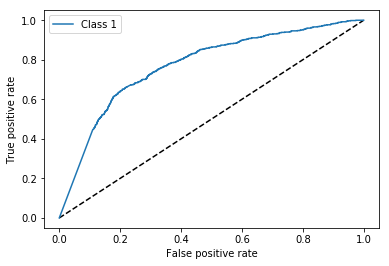

Roc score:  0.7722056032466273
Predicted:  0
y_test:  <class 'pandas.core.series.Series'>
0
Accuracy score:  0.8677749970206173


In [84]:
get_model_results(predictors, target, model, oversample=True)

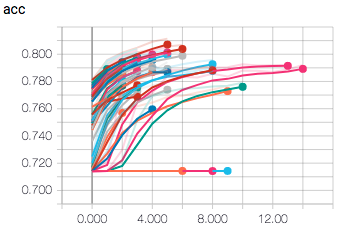

In [4]:
from IPython.display import Image
Image("../dnn_accuracy.png")

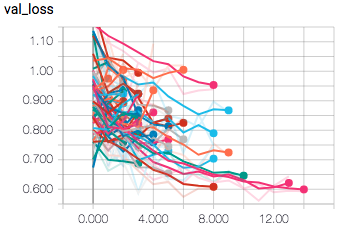

In [6]:
Image("../dnn_val_loss.png")

Using these plots generated from TensorBoard it looks like a model with 10 hidden layers and 15 nodes per layer strikes the best balance between validation loss (0.60) and accuracy (0.79) of the models tested.  There are other 